In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
df = pd.read_pickle('datasets/features-label-text-represented-subset.pkl')
df_copy = df.copy()

In [3]:
df_copy.head()

,CIK,file_id,year,roe,opinc,nopinc,token_count,roe_next_year,tone,text_vector
0,1750,3,2005,0.095362,0.131652,-0.015174,2120,0.127945,-0.000472,"[0.90494365, 0.074863456, -0.22782834, 0.33961..."
1,1750,4,2006,0.127945,0.149182,-0.022282,3219,0.139220,0.000000,"[0.9111878, 0.08885506, -0.31519878, 0.4127013..."
2,1750,7,2009,0.063607,0.105913,-0.030043,3364,0.088296,0.000000,"[0.7394947, 0.017999234, -0.41983142, 0.052898..."
3,1750,8,2010,0.088296,0.136418,-0.040048,3045,0.079613,-0.000328,"[0.9311413, 0.0732959, -0.42346224, 0.16167574..."
4,1750,9,2011,0.079613,0.138888,-0.026679,2503,0.061607,-0.000799,"[0.8763539, 0.0571177, -0.4936092, 0.20794152,..."


Retrieve train and test file_ids

In [4]:
train_ids = pd.read_csv('train-test-ids/train-ids.csv')
test_ids = pd.read_csv('train-test-ids/test-ids.csv')

In [5]:
train_data = df_copy[df_copy['file_id'].isin(train_ids['file_id'].astype(str))]
test_data = df_copy[df_copy['file_id'].isin(test_ids['file_id'].astype(str))]

In [6]:
train_data.shape

(32113, 10)

In [7]:
test_data.shape

(11177, 10)

In [8]:
def get_test_mse(model, test_features, test_label):
    test_pred = model.predict(test_features)
    return mean_squared_error(test_label, test_pred)

def get_test_mae(model, test_features, test_label):
    test_pred = model.predict(test_features)
    return mean_absolute_error(test_label, test_pred)

# n: length of test data
# p: number of predictors
def get_test_adj_r2(model, test_features, test_label, n, p):
    test_pred = model.predict(test_features)
    r2 = r2_score(test_label, test_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2

# Part 1: OPINC and NOPINC only

Model2.0 OPINC_t + NOPINC_t -> ROE_t+1

In [9]:
train_features_m2_0 = train_data[['opinc', 'nopinc']].to_numpy()
train_label_m2_0 = train_data['roe_next_year'].to_numpy()

test_features_m2_0 = test_data[['opinc', 'nopinc']].to_numpy()
test_label_m2_0 = test_data['roe_next_year'].to_numpy()

In [10]:
# normalisation
train_features_m2_0_norm = (train_features_m2_0 - np.mean(train_features_m2_0, axis=0)) / np.std(train_features_m2_0, axis=0)
test_features_m2_0_norm = (test_features_m2_0 - np.mean(test_features_m2_0, axis=0)) / np.std(test_features_m2_0, axis=0)

Model2.0 Linear regression

In [15]:
model2_0_lr = LinearRegression()
model2_0_lr.fit(train_features_m2_0_norm, train_label_m2_0)

LinearRegression()

In [16]:
print(model2_0_lr.coef_)

[ 0.14488545 -0.00088914]


In [17]:
# save model as binary file
pickle.dump(model2_0_lr, open('finalised-models/model2-0-lr.pkl', 'wb'))

In [18]:
model2_0_lr_mse = get_test_mse(model2_0_lr,
             test_features_m2_0_norm,
             test_label_m2_0)
model2_0_lr_mse

0.04160537363027809

In [11]:
model2_0_lr_pkl = pickle.load(open('finalised-models/model2-0-lr.pkl', 'rb'))
get_test_mae(
    model2_0_lr_pkl,
    test_features_m2_0_norm,
    test_label_m2_0
)

0.12939683085787376

In [13]:
n = test_data.shape[0]
p = 2

In [15]:
get_test_adj_r2(
    model2_0_lr_pkl,
    test_features_m2_0_norm,
    test_label_m2_0,
    n,
    p
)

0.3581859351816479

Model2.0 Ridge regression

In [26]:
model2_0_ridge = RidgeCV(alphas=[1e-1, 1, 3, 5, 10, 15, 20])
model2_0_ridge.fit(train_features_m2_0_norm, train_label_m2_0)

RidgeCV(alphas=[0.1, 1, 3, 5, 10, 15, 20])

In [27]:
print(model2_0_ridge.alpha_)

10.0


In [28]:
# save model as binary file
pickle.dump(model2_0_ridge, open('finalised-models/model2-0-ridge.pkl', 'wb'))

In [29]:
model2_0_ridge_mse = get_test_mse(model2_0_ridge,
             test_features_m2_0_norm,
             test_label_m2_0)
model2_0_ridge_mse

0.041606200416528495

In [16]:
model2_0_ridge_pkl = pickle.load(open('finalised-models/model2-0-ridge.pkl', 'rb'))
get_test_mae(
    model2_0_ridge_pkl,
    test_features_m2_0_norm,
    test_label_m2_0
)

0.12940125074051068

In [17]:
get_test_adj_r2(
    model2_0_ridge_pkl,
    test_features_m2_0_norm,
    test_label_m2_0,
    n,
    p
)

0.3581731809867492

Model2.0 Decision tree

In [31]:
model2_0_dt = DecisionTreeRegressor(max_depth=3)
model2_0_dt.fit(train_features_m2_0_norm, train_label_m2_0)

DecisionTreeRegressor(max_depth=3)

In [32]:
get_test_mse(model2_0_dt,
             test_features_m2_0_norm,
             test_label_m2_0)

0.04122108457059247

In [33]:
# tune hyperparameters
dt_params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [50, 100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

model2_0_dt_tune = GridSearchCV(estimator=model2_0_dt,
                                param_grid=dt_params,
                                n_jobs=-1)
model2_0_dt_tune.fit(train_features_m2_0_norm, train_label_m2_0)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/l

GridSearchCV(estimator=DecisionTreeRegressor(max_depth=3), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [50, 100, 200, 300, 400, 500],
                         'splitter': ['best', 'random']})

In [34]:
model2_0_dt_tune.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 100,
 'splitter': 'best'}

In [35]:
model2_0_dt_best = model2_0_dt_tune.best_estimator_
model2_0_dt_best_mse = get_test_mse(model2_0_dt_best,
            test_features_m2_0_norm,
            test_label_m2_0)
model2_0_dt_best_mse

0.0399957476950726

In [37]:
pickle.dump(model2_0_dt_best, open('finalised-models/model2-0-dt.pkl', 'wb'))

In [18]:
model2_0_dt_pkl = pickle.load(open('finalised-models/model2-0-dt.pkl', 'rb'))
get_test_mae(
    model2_0_dt_pkl,
    test_features_m2_0_norm,
    test_label_m2_0
)

0.12329403462135863

In [19]:
get_test_adj_r2(
    model2_0_dt_pkl,
    test_features_m2_0_norm,
    test_label_m2_0,
    n,
    p
)

0.3830163951479886

Model2.0 Gradient boosting

In [38]:
model2_0_gb = GradientBoostingRegressor()
model2_0_gb.fit(train_features_m2_0_norm, train_label_m2_0)

GradientBoostingRegressor()

In [39]:
get_test_mse(model2_0_gb,
             test_features_m2_0_norm,
             test_label_m2_0)

0.039709132548050814

In [42]:
# tune hyperparameters
gb_params = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_split': [10, 20, 50, 100, 150, 200],
    'min_samples_leaf': [10, 50, 100, 200, 400, 500],
    'learning_rate': [0.1, 0.01, 0.001]
}

# use RandomizedSearchCV for save computation
model2_0_gb_tune = RandomizedSearchCV(estimator=model2_0_gb,
                                      param_distributions=gb_params,
                                      random_state=42,
                                      n_iter=100,
                                      n_jobs=-1)
model2_0_gb_tune.fit(train_features_m2_0_norm, train_label_m2_0)

RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [2, 3, 5, 10, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [10, 50, 100, 200,
                                                             400, 500],
                                        'min_samples_split': [10, 20, 50, 100,
                                                              150, 200],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42)

In [43]:
model2_0_gb_tune.best_params_

{'n_estimators': 100,
 'min_samples_split': 200,
 'min_samples_leaf': 200,
 'max_features': 'log2',
 'max_depth': 5,
 'learning_rate': 0.1}

In [44]:
model2_0_gb_best = model2_0_gb_tune.best_estimator_
model2_0_gb_best_mse = get_test_mse(model2_0_gb_best,
             test_features_m2_0_norm,
             test_label_m2_0)
model2_0_gb_best_mse

0.03963290987631139

In [47]:
pickle.dump(model2_0_gb_best, open('finalised-models/model2-0-gb.pkl', 'wb'))

In [20]:
model2_0_gb_pkl = pickle.load(open('finalised-models/model2-0-gb.pkl', 'rb'))
get_test_mae(
    model2_0_gb_pkl,
    test_features_m2_0_norm,
    test_label_m2_0
)

0.12236073412159008

In [21]:
get_test_adj_r2(
    model2_0_gb_pkl,
    test_features_m2_0_norm,
    test_label_m2_0,
    n,
    p
)

0.38861361481000567

# Part 2: OPINC + NOPINC + LMD tone

Model2.1 OPINC_t + NOPINC_t + tone_t -> ROE_t+1

In [22]:
train_features_m2_1 = train_data[['opinc', 'nopinc', 'tone']].to_numpy()
train_label_m2_1 = train_data['roe_next_year'].to_numpy()

test_features_m2_1 = test_data[['opinc', 'nopinc', 'tone']].to_numpy()
test_label_m2_1 = test_data['roe_next_year'].to_numpy()

In [23]:
# normalisation
train_features_m2_1_norm = (train_features_m2_1 - np.mean(train_features_m2_1, axis=0)) / np.std(train_features_m2_1, axis=0)
test_features_m2_1_norm = (test_features_m2_1 - np.mean(test_features_m2_1, axis=0)) / np.std(test_features_m2_1, axis=0)

Model2.1 Linear regression

In [78]:
model2_1_lr = LinearRegression()
model2_1_lr.fit(train_features_m2_1_norm, train_label_m2_1)

LinearRegression()

In [79]:
print(model2_1_lr.coef_)

[ 0.14488762 -0.00084953  0.00316303]


In [80]:
model2_1_lr_mse = get_test_mse(model2_1_lr,
             test_features_m2_1_norm,
             test_label_m2_1)
model2_1_lr_mse

0.0416033640994507

In [82]:
pickle.dump(model2_1_lr, open('finalised-models/model2-1-lr.pkl', 'wb'))

In [24]:
model2_1_lr_pkl = pickle.load(open('finalised-models/model2-1-lr.pkl', 'rb'))
print('MAE: ', get_test_mae(
    model2_1_lr_pkl,
    test_features_m2_1_norm,
    test_label_m2_1
))

n = test_data.shape[0]
p = 3
print('Adjusted R^2: ', get_test_adj_r2(
    model2_1_lr_pkl,
    test_features_m2_1_norm,
    test_label_m2_1,
    n,
    p
))

MAE:  0.12938948230342026
Adjusted R^2:  0.35815949413436177


Model2.1 Ridge regression

In [83]:
model2_1_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 3, 5, 10, 15, 20])
model2_1_ridge.fit(train_features_m2_1_norm, train_label_m2_1)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 3, 5, 10, 15, 20])

In [84]:
print(model2_1_ridge.alpha_)

15.0


In [85]:
model2_1_ridge_mse = get_test_mse(model2_1_ridge,
             test_features_m2_1_norm,
             test_label_m2_1)
model2_1_ridge_mse

0.041604605797285255

In [87]:
pickle.dump(model2_1_ridge, open('finalised-models/model2-1-ridge.pkl', 'wb'))

In [25]:
model2_1_ridge_pkl = pickle.load(open('finalised-models/model2-1-ridge.pkl', 'rb'))
print('MAE: ', get_test_mae(
    model2_1_ridge_pkl,
    test_features_m2_1_norm,
    test_label_m2_1
))

n = test_data.shape[0]
p = 3
print('Adjusted R^2: ', get_test_adj_r2(
    model2_1_ridge_pkl,
    test_features_m2_1_norm,
    test_label_m2_1,
    n,
    p
))

MAE:  0.12939603139850678
Adjusted R^2:  0.3581403377035415


Model2.1 Decision tree

In [88]:
model2_1_dt = DecisionTreeRegressor(max_depth=3)
model2_1_dt.fit(train_features_m2_1_norm, train_label_m2_1)

DecisionTreeRegressor(max_depth=3)

In [89]:
get_test_mse(model2_1_dt,
             test_features_m2_1_norm,
             test_label_m2_1)

0.041221084570592474

In [90]:
# tune hyperparameters
dt_params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [100, 200, 300, 500, 800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

model2_1_dt_tune = GridSearchCV(estimator=model2_1_dt,
                                param_grid=dt_params,
                                n_jobs=-1)
model2_1_dt_tune.fit(train_features_m2_1_norm, train_label_m2_1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/l

GridSearchCV(estimator=DecisionTreeRegressor(max_depth=3), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [100, 200, 300, 500, 800],
                         'splitter': ['best', 'random']})

In [91]:
model2_1_dt_tune.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 200,
 'splitter': 'best'}

In [92]:
model2_1_dt_best = model2_1_dt_tune.best_estimator_
model2_1_dt_best_mse = get_test_mse(model2_1_dt_best,
             test_features_m2_1_norm,
             test_label_m2_1)
model2_1_dt_best_mse

0.040045273521608186

In [94]:
pickle.dump(model2_1_dt_best, open('finalised-models/model2-1-dt.pkl', 'wb'))

In [26]:
model2_1_dt_pkl = pickle.load(open('finalised-models/model2-1-dt.pkl', 'rb'))
print('MAE: ', get_test_mae(
    model2_1_dt_pkl,
    test_features_m2_1_norm,
    test_label_m2_1
))

n = test_data.shape[0]
p = 3
print('Adjusted R^2: ', get_test_adj_r2(
    model2_1_dt_pkl,
    test_features_m2_1_norm,
    test_label_m2_1,
    n,
    p
))

MAE:  0.12355432747956763
Adjusted R^2:  0.38219710903195436


Model2.1 Gradient boosting

In [95]:
model2_1_gb = GradientBoostingRegressor()
model2_1_gb.fit(train_features_m2_1_norm, train_label_m2_1)

GradientBoostingRegressor()

In [96]:
get_test_mse(model2_1_gb,
             test_features_m2_1_norm,
             test_label_m2_1)

0.03969334914403256

In [97]:
# tune hyperparameters
gb_params = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 3, 5, 10, 20, 50],
    'min_samples_split': [5, 10, 20, 50, 100, 200],
    'min_samples_leaf': [100, 200, 300, 500, 800],
    'learning_rate': [0.1, 0.01, 0.001]
}

# use RandomizedSearchCV for save computation
model2_1_gb_tune = RandomizedSearchCV(estimator=model2_1_gb,
                                      param_distributions=gb_params,
                                      random_state=42,
                                      n_iter=100,
                                      n_jobs=-1)
model2_1_gb_tune.fit(train_features_m2_1_norm, train_label_m2_1)

RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [2, 3, 5, 10, 20, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [100, 200, 300, 500,
                                                             800],
                                        'min_samples_split': [5, 10, 20, 50,
                                                              100, 200],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42)

In [98]:
model2_1_gb_tune.best_params_

{'n_estimators': 150,
 'min_samples_split': 50,
 'min_samples_leaf': 200,
 'max_features': 'log2',
 'max_depth': 5,
 'learning_rate': 0.1}

In [99]:
model2_1_gb_best = model2_1_gb_tune.best_estimator_
model2_1_gb_best_mse = get_test_mse(model2_1_gb_best,
             test_features_m2_1_norm,
             test_label_m2_1)
model2_1_gb_best_mse

0.039675074988406375

In [102]:
pickle.dump(model2_1_gb_best, open('finalised-models/model2-1-gb.pkl', 'wb'))

In [27]:
model2_1_gb_pkl = pickle.load(open('finalised-models/model2-1-gb.pkl', 'rb'))
print('MAE: ', get_test_mae(
    model2_1_gb_pkl,
    test_features_m2_1_norm,
    test_label_m2_1
))

n = test_data.shape[0]
p = 3
print('Adjusted R^2: ', get_test_adj_r2(
    model2_1_gb_pkl,
    test_features_m2_1_norm,
    test_label_m2_1,
    n,
    p
))

MAE:  0.12258596217015325
Adjusted R^2:  0.3879083878903893


# Part 3: OPINC + NOPINC + word embedding

Model2.2 OPINC_t, NOPINC_t, text_vector_t -> ROE_t+1

In [28]:
# features concatenation
train_features_m2_2 = np.concatenate((np.array(train_data['text_vector'].tolist()), train_data['opinc'].values.reshape(-1, 1), train_data['nopinc'].values.reshape(-1, 1)), axis=1)
train_label_m2_2 = train_data['roe_next_year'].values

test_features_m2_2 = np.concatenate((np.array(test_data['text_vector'].tolist()), test_data['opinc'].values.reshape(-1, 1), test_data['nopinc'].values.reshape(-1, 1)), axis=1)
test_label_m2_2 = test_data['roe_next_year'].values

In [29]:
# normalisation
train_features_m2_2_norm = (train_features_m2_2 - np.mean(train_features_m2_2, axis=0)) / np.std(train_features_m2_2, axis=0)
test_features_m2_2_norm = (test_features_m2_2 - np.mean(test_features_m2_2, axis=0)) / np.std(test_features_m2_2, axis=0)

Model2.2 Linear regression

In [110]:
model2_2_lr = LinearRegression()
model2_2_lr.fit(train_features_m2_2_norm, train_label_m2_2)

LinearRegression()

In [111]:
model2_2_lr_mse = get_test_mse(model2_2_lr,
             test_features_m2_2_norm,
             test_label_m2_2)
model2_2_lr_mse

0.039500424532768794

In [113]:
pickle.dump(model2_2_lr, open('finalised-models/model2-2-lr.pkl', 'wb'))

In [32]:
model2_2_lr_pkl = pickle.load(open('finalised-models/model2-2-lr.pkl', 'rb'))
print('MAE: ', get_test_mae(
    model2_2_lr_pkl,
    test_features_m2_2_norm,
    test_label_m2_2
))

n = test_data.shape[0]
p = train_features_m2_2.shape[1]
print('Adjusted R^2: ', get_test_adj_r2(
    model2_2_lr_pkl,
    test_features_m2_2_norm,
    test_label_m2_2,
    n,
    p
))

MAE:  0.12504756877562107
Adjusted R^2:  0.38515490225224935


Model2.2 Ridge regression

In [120]:
model2_2_ridge = RidgeCV(alphas=[1e-1, 1, 3, 5, 10, 15, 20, 30, 50, 80, 100])
model2_2_ridge.fit(train_features_m2_2_norm, train_label_m2_2)

RidgeCV(alphas=[0.1, 1, 3, 5, 10, 15, 20, 30, 50, 80, 100])

In [121]:
print(model2_2_ridge.alpha_)

100.0


In [122]:
model2_2_ridge_mse = get_test_mse(model2_2_ridge,
             test_features_m2_2_norm,
             test_label_m2_2)
model2_2_ridge_mse

0.03949904042291754

In [124]:
pickle.dump(model2_2_ridge, open('finalised-models/model2-2-ridge.pkl', 'wb'))

In [2]:
model2_2_ridge_pkl = pickle.load(open('finalised-models/model2-2-ridge.pkl', 'rb'))

In [33]:
print('MAE: ', get_test_mae(
    model2_2_ridge_pkl,
    test_features_m2_2_norm,
    test_label_m2_2
))

n = test_data.shape[0]
p = train_features_m2_2.shape[1]
print('Adjusted R^2: ', get_test_adj_r2(
    model2_2_ridge_pkl,
    test_features_m2_2_norm,
    test_label_m2_2,
    n,
    p
))

MAE:  0.12494344390007714
Adjusted R^2:  0.385176446657578


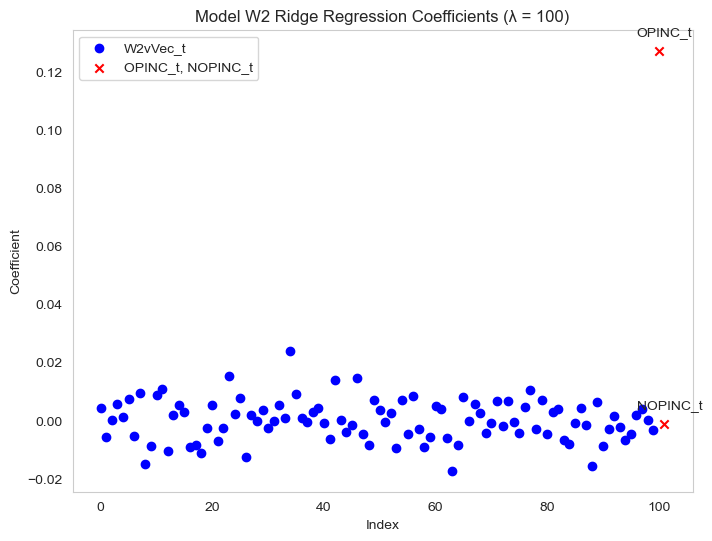

In [4]:
coefs = model2_2_ridge_pkl.coef_
coefs_w2v = coefs[:-2]
coefs_comp = coefs[-2:]

plt.figure(figsize=(8, 6))
plt.scatter(range(len(coefs_w2v)), coefs_w2v, c='blue', label='W2vVec_t', marker='o')
plt.scatter(range(len(coefs_w2v), len(coefs_w2v) + len(coefs_comp)), coefs_comp, c='red', label='OPINC_t, NOPINC_t', marker='x')
plt.annotate('OPINC_t', (101, coefs_comp[0]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('NOPINC_t', (102, coefs_comp[1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Index')
plt.ylabel('Coefficient')
plt.title('Model W2 Ridge Regression Coefficients (λ = 100)')
plt.legend()
plt.grid()
plt.show()

Model2.2 Decision tree

In [125]:
# with trial hyperparameters
model2_2_dt = DecisionTreeRegressor(max_depth=3)
model2_2_dt.fit(train_features_m2_2_norm, train_label_m2_2)

DecisionTreeRegressor(max_depth=3)

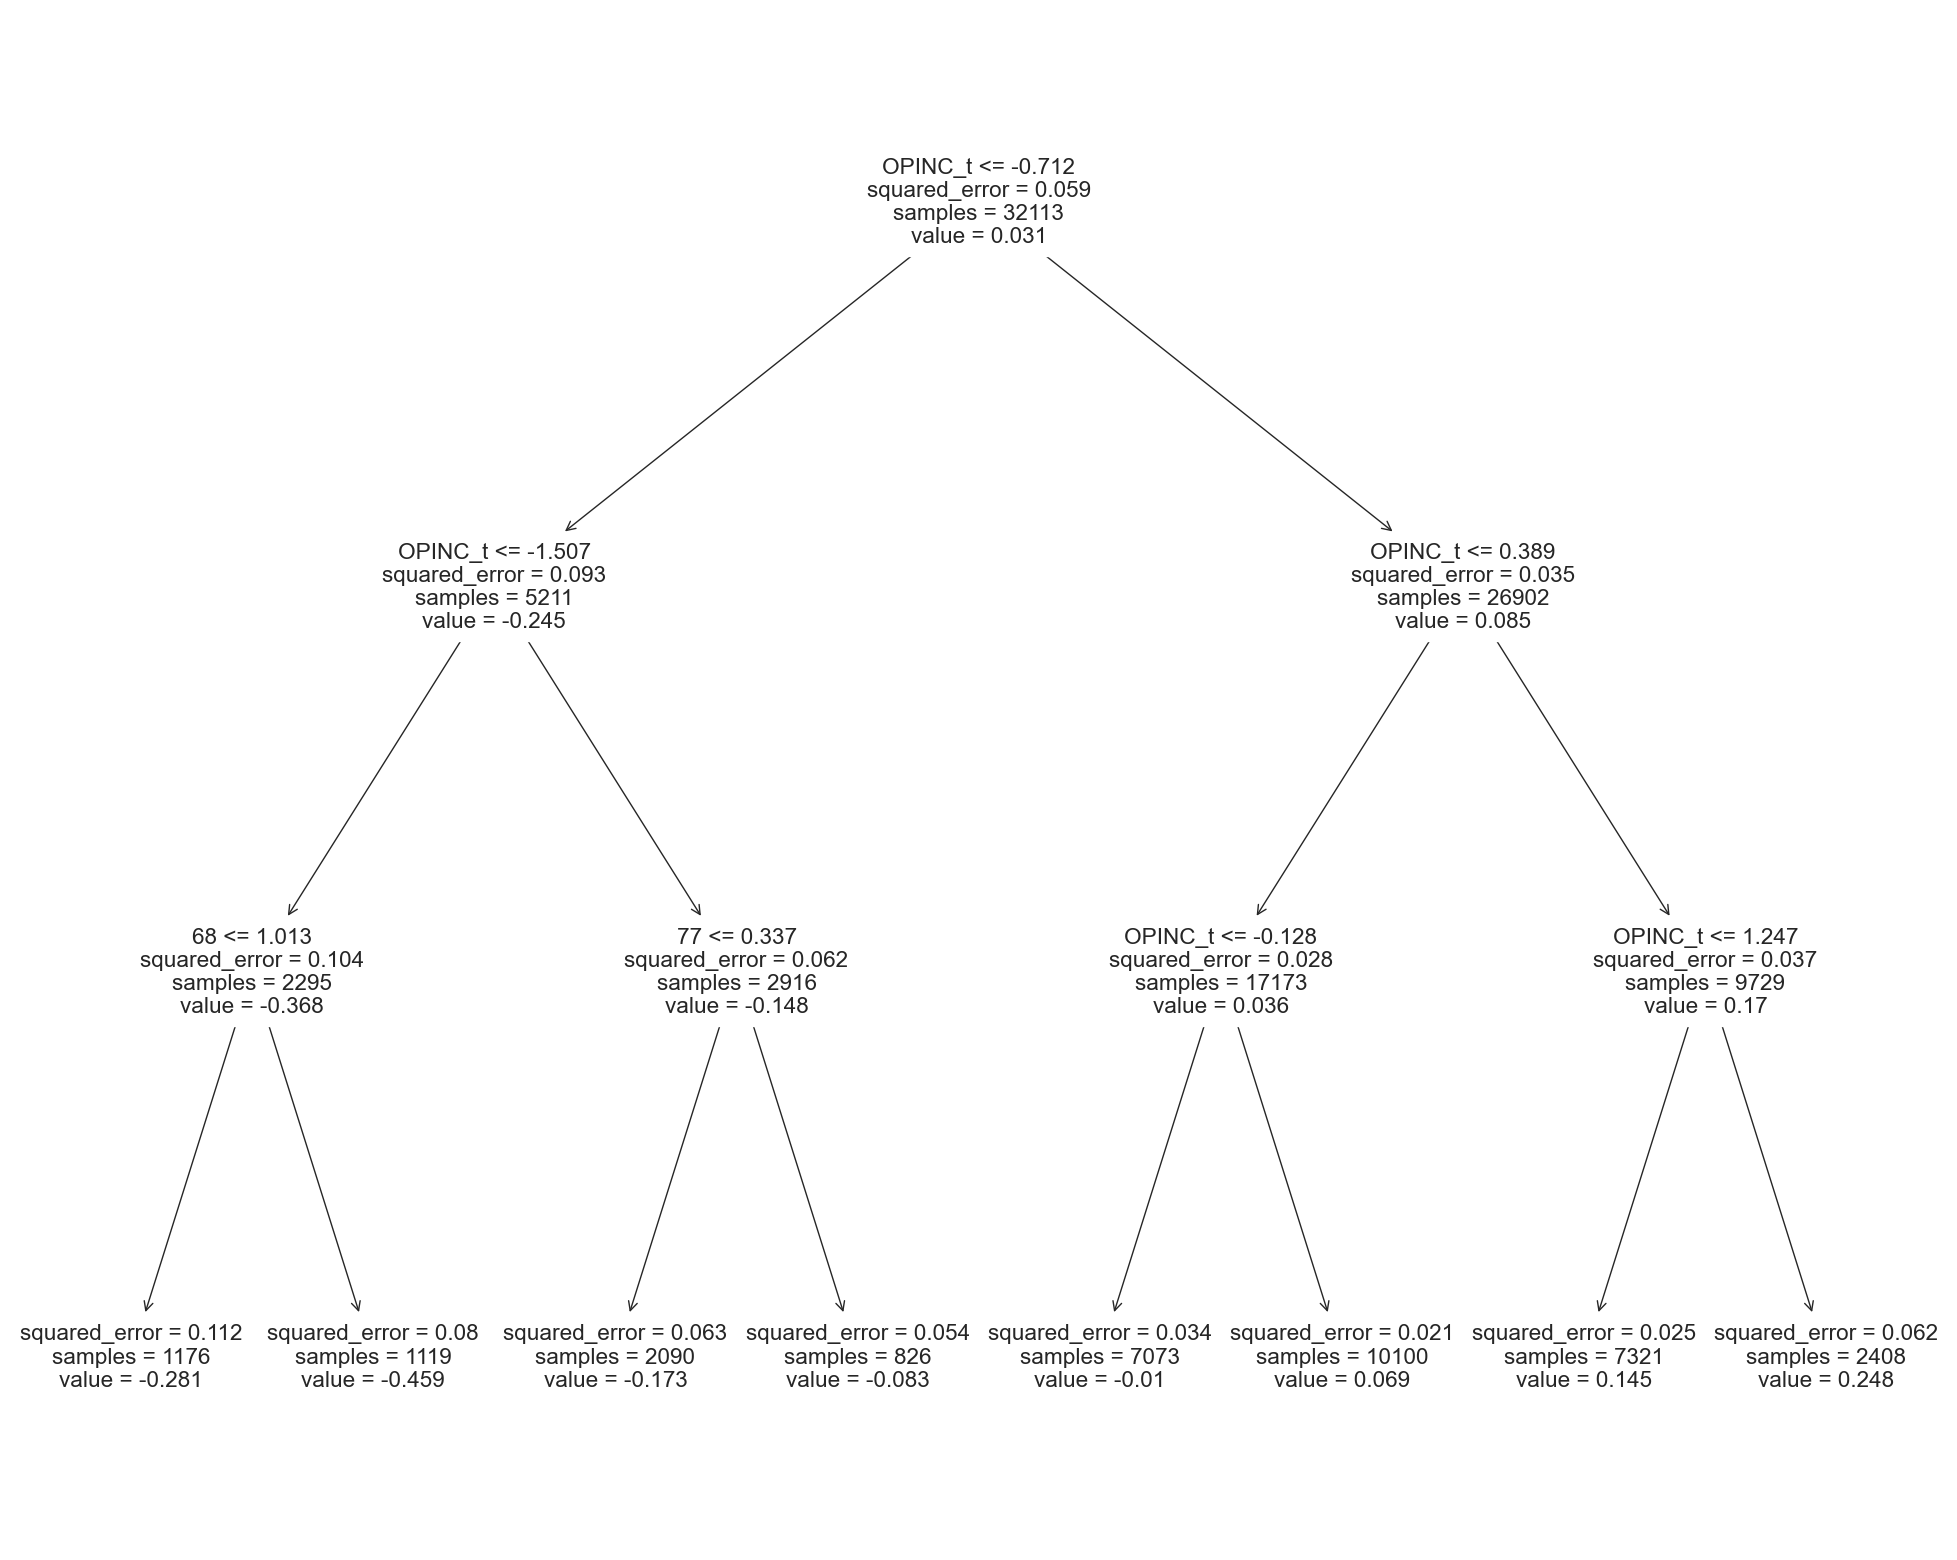

In [126]:
fig = plt.figure(figsize=(25,20))

features_names = np.append(np.arange(1, 101), ['OPINC_t', 'NOPINC_t'])
_ = tree.plot_tree(model2_2_dt, feature_names=features_names)

In [127]:
get_test_mse(model2_2_dt,
             test_features_m2_2_norm,
             test_label_m2_2)

0.04139471423899232

In [128]:
# tune hyperparameters
dt_params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [10, 20, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

model2_2_dt_tune = GridSearchCV(estimator=model2_2_dt,
                           param_grid=dt_params,
                           n_jobs=-1)
model2_2_dt_tune.fit(train_features_m2_2_norm, train_label_m2_2)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/l

GridSearchCV(estimator=DecisionTreeRegressor(max_depth=3), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [10, 20, 50, 100, 200],
                         'splitter': ['best', 'random']})

In [129]:
model2_2_dt_tune.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 100,
 'splitter': 'best'}

In [130]:
model2_2_dt_best = model2_2_dt_tune.best_estimator_
model2_2_dt_best_mse = get_test_mse(model2_2_dt_best,
             test_features_m2_2_norm,
             test_label_m2_2)
model2_2_dt_best_mse

0.03980498559752749

In [132]:
pickle.dump(model2_2_dt_best, open('finalised-models/model2-2-dt.pkl', 'wb'))

In [5]:
model2_2_dt_pkl = pickle.load(open('finalised-models/model2-2-dt.pkl', 'rb'))

In [34]:
print('MAE: ', get_test_mae(
    model2_2_dt_pkl,
    test_features_m2_2_norm,
    test_label_m2_2
))

n = test_data.shape[0]
p = train_features_m2_2.shape[1]
print('Adjusted R^2: ', get_test_adj_r2(
    model2_2_dt_pkl,
    test_features_m2_2_norm,
    test_label_m2_2,
    n,
    p
))

MAE:  0.12320859905075338
Adjusted R^2:  0.3804142474403909


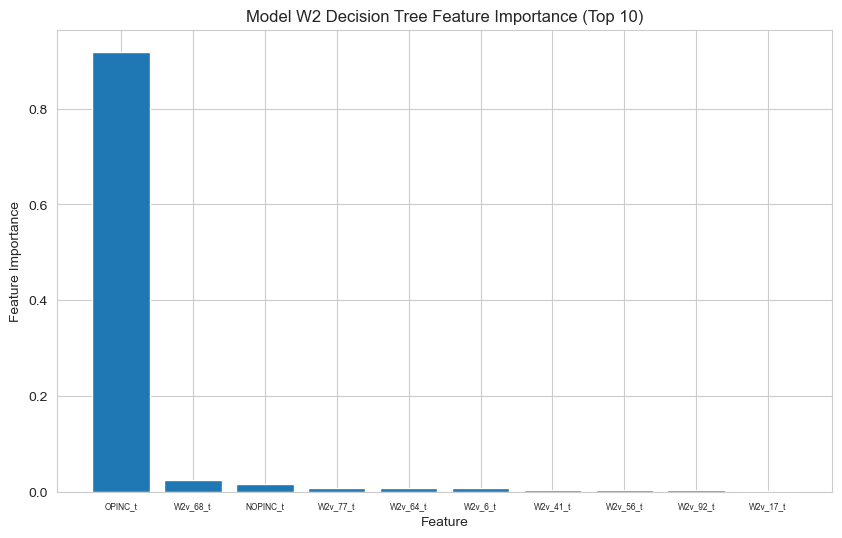

In [6]:
feature_importances = model2_2_dt_pkl.feature_importances_
feature_names = [f"W2v_{i}_t" for i in range(1, 101)] + ['OPINC_t', 'NOPINC_t']

sorted_indices = np.argsort(feature_importances)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(0, 10), sorted_feature_importances[:10])
plt.xticks(range(0, 10), sorted_feature_names[:10], fontsize=6)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Model W2 Decision Tree Feature Importance (Top 10)')
plt.show()

Model2.2 Gradient boosting

In [133]:
model2_2_gb = GradientBoostingRegressor()

In [134]:
# with default parameters
model2_2_gb.fit(train_features_m2_2_norm, train_label_m2_2)

GradientBoostingRegressor()

In [135]:
get_test_mse(model2_2_gb,
             test_features_m2_2_norm,
             test_label_m2_2)

0.03770451987004551

In [136]:
# tune hyperparameters
gb_params = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'min_samples_leaf': [10, 50, 100, 200, 300, 500],
    'learning_rate': [0.1, 0.01, 0.001]
}

# use RandomizedSearchCV for save computation
model2_2_gb_tune = RandomizedSearchCV(estimator=model2_2_gb,
                                param_distributions=gb_params,
                                random_state=42,
                                n_iter=100,
                                n_jobs=-1)
model2_2_gb_tune.fit(train_features_m2_2_norm, train_label_m2_2)

RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [3, 5, 10, 20, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [10, 50, 100, 200,
                                                             300, 500],
                                        'min_samples_split': [2, 5, 10, 20, 50,
                                                              100],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42)

In [137]:
model2_2_gb_tune.best_params_

{'n_estimators': 150,
 'min_samples_split': 20,
 'min_samples_leaf': 100,
 'max_features': 'sqrt',
 'max_depth': 5,
 'learning_rate': 0.1}

In [138]:
model2_2_gb_best = model2_2_gb_tune.best_estimator_
model2_2_gb_best_mse = get_test_mse(model2_2_gb_best,
             test_features_m2_2_norm,
             test_label_m2_2)
model2_2_gb_best_mse

0.037460327259292346

In [140]:
# save the best gb model as binary file
pickle.dump(model2_2_gb_best, open('finalised-models/model2-2-gb.pkl', 'wb'))

In [7]:
model2_2_gb_pkl = pickle.load(open('finalised-models/model2-2-gb.pkl', 'rb'))

In [35]:
print('MAE: ', get_test_mae(
    model2_2_gb_pkl,
    test_features_m2_2_norm,
    test_label_m2_2
))

n = test_data.shape[0]
p = train_features_m2_2.shape[1]
print('Adjusted R^2: ', get_test_adj_r2(
    model2_2_gb_pkl,
    test_features_m2_2_norm,
    test_label_m2_2,
    n,
    p
))

MAE:  0.12023238804517232
Adjusted R^2:  0.4169101003890432


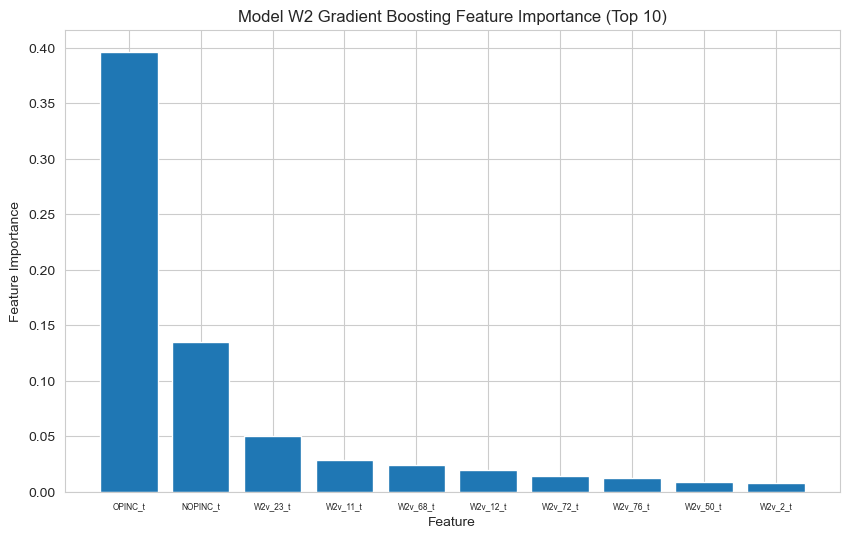

In [8]:
feature_importances = model2_2_gb_pkl.feature_importances_
feature_names = [f"W2v_{i}_t" for i in range(1, 101)] + ['OPINC_t', 'NOPINC_t']

sorted_indices = np.argsort(feature_importances)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(0, 10), sorted_feature_importances[:10])
plt.xticks(range(0, 10), sorted_feature_names[:10], fontsize=6)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Model W2 Gradient Boosting Feature Importance (Top 10)')
plt.show()

In [9]:
model2_2_gb_pkl.feature_importances_

array([0.00216585, 0.00826817, 0.00439368, 0.00172299, 0.00159403,
       0.00736358, 0.00110794, 0.00594426, 0.00111205, 0.00127464,
       0.02835215, 0.01953241, 0.00224525, 0.00181464, 0.00548096,
       0.00615536, 0.00370733, 0.00698517, 0.00766936, 0.00254471,
       0.00124765, 0.00176083, 0.05044962, 0.00180893, 0.0028489 ,
       0.00513198, 0.00152235, 0.00287182, 0.0037244 , 0.00249889,
       0.00196043, 0.00274781, 0.00603039, 0.0048606 , 0.00385843,
       0.00816661, 0.00668154, 0.00123543, 0.00278073, 0.00109189,
       0.00570762, 0.00416519, 0.00505843, 0.00249371, 0.00131334,
       0.00457669, 0.00205703, 0.00771082, 0.00373433, 0.00867874,
       0.00207435, 0.00169918, 0.00159273, 0.00270168, 0.00611651,
       0.00353495, 0.00134164, 0.00566106, 0.00233191, 0.00116988,
       0.00297128, 0.00198763, 0.00386181, 0.0043361 , 0.00252303,
       0.0035451 , 0.00239161, 0.02450755, 0.00218707, 0.00423163,
       0.00249024, 0.0137718 , 0.00394681, 0.00097097, 0.00485